In [1]:
import time
import sys; sys.path.insert(0, "..")
from src.models import NLM, LUNA
from src.utils import generate_data, format_time, neg_log_likelihood, epistemic_uncertainty

In [2]:
from autograd import numpy as np
import matplotlib.pyplot as plt

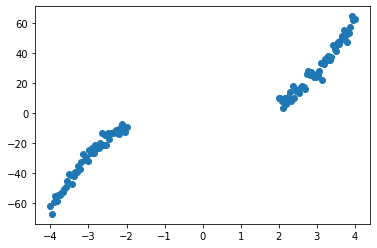

In [3]:
x, y, x_test, y_test = generate_data(number_of_points=50, noise_variance=9)
plt.scatter(x, y)
plt.show()

# Extract test data (gap vs. non-gap)
gap_idx = np.logical_and(x_test > -2, x_test < 2)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = y_test[gap_idx].reshape(1,-1)

non_gap_idx = np.logical_or(np.logical_and(x_test > -4, x_test < -2),np.logical_and(x_test > 2, x_test < 4))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = y_test[non_gap_idx].reshape(1,-1)

In [5]:
def experiment_NLM_1D(reg_param, step_size=1e-2, max_iteration=1500, x_train=x, y_train=y):
    activation_fn_type = 'relu'
    activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

    input_dim = 1
    output_dim = 1
    width = [50,50] # using the architecture used in the paper

    architecture = {
        'width': width,
        'input_dim': input_dim,
        'output_dim': output_dim,
        'activation_fn_type': 'relu',
        'activation_fn_params': 'rate=1',
        'activation_fn': activation_fn
    }

    params = {
        'step_size': step_size,
        'max_iteration': max_iteration,
        'random_restarts': 1,
        'reg_param': reg_param
    }

    rand_state = 207
    random = np.random.RandomState(rand_state)

    nlm = NLM(architecture, random=random)
    print("")
    print(f"===== NLM [ Regularization: {reg_param} ]  =====")
    print("")
    t0 = time.time()
    nlm.fit(x_train, y_train, params)
    print("")
    print("Training took {:} (h:mm:ss)".format(format_time(time.time()-t0)))

    return nlm

In [6]:
reg_grid = [0., 0.001, 0.01, 0.1, 1., 10., 100.,1000.]

step_size = 1e-2
max_iteration_nlm = 2000


In [7]:
nlm_list = []
for reg in reg_grid:
    nlm = experiment_NLM_1D(reg, step_size = step_size, max_iteration = max_iteration_nlm)
    nlm_list.append(nlm)


===== NLM [ Regularization: 0.0 ]  =====

Iteration 0 loss 8690.182801164432; gradient mag: 19805.501624875844
Iteration 100 loss 81.43957000385107; gradient mag: 71.80359294777526
Iteration 200 loss 19.467527728710277; gradient mag: 38.97482241127934
Iteration 300 loss 9.426462021586396; gradient mag: 6.0122389729148935
Iteration 400 loss 9.099414965613603; gradient mag: 0.7211727502924506
Iteration 500 loss 9.011559654893755; gradient mag: 2.288546323305966
Iteration 600 loss 8.984068139950045; gradient mag: 0.5047853311026058
Iteration 700 loss 8.979288419121517; gradient mag: 0.7217848901024426
Iteration 800 loss 8.97991995446485; gradient mag: 4.398751463824599
Iteration 900 loss 8.974870021956818; gradient mag: 4.003906764950505
Iteration 1000 loss 8.969903847304062; gradient mag: 1.520819365694233
Iteration 1100 loss 8.966701689409573; gradient mag: 1.2368709513333194
Iteration 1200 loss 8.9631223180889; gradient mag: 1.4920489618422899
Iteration 1300 loss 8.959377402526199; gr

Iteration 1000 loss 13.39582495830101; gradient mag: 14.583478496491237
Iteration 1100 loss 13.315770505345895; gradient mag: 10.269445081348733
Iteration 1200 loss 13.247871614648027; gradient mag: 34.362447112710235
Iteration 1300 loss 13.162910838982668; gradient mag: 14.284829594582598
Iteration 1400 loss 13.082631849763775; gradient mag: 13.010433165966193
Iteration 1500 loss 13.023168577553246; gradient mag: 32.490401878868404
Iteration 1600 loss 12.975922078165299; gradient mag: 19.976854308163333
Iteration 1700 loss 12.886382201142014; gradient mag: 7.97816992501314
Iteration 1800 loss 12.910343730835944; gradient mag: 60.81678008800103
Iteration 1900 loss 12.743920424932362; gradient mag: 11.244694513724726

Training took 0:00:44 (h:mm:ss)

===== NLM [ Regularization: 100.0 ]  =====

Iteration 0 loss 8796.59525114812; gradient mag: 19805.681763710687
Iteration 100 loss 144.62560019417782; gradient mag: 108.93371089332247
Iteration 200 loss 68.55190032306282; gradient mag: 8.50

## Plot prior samples

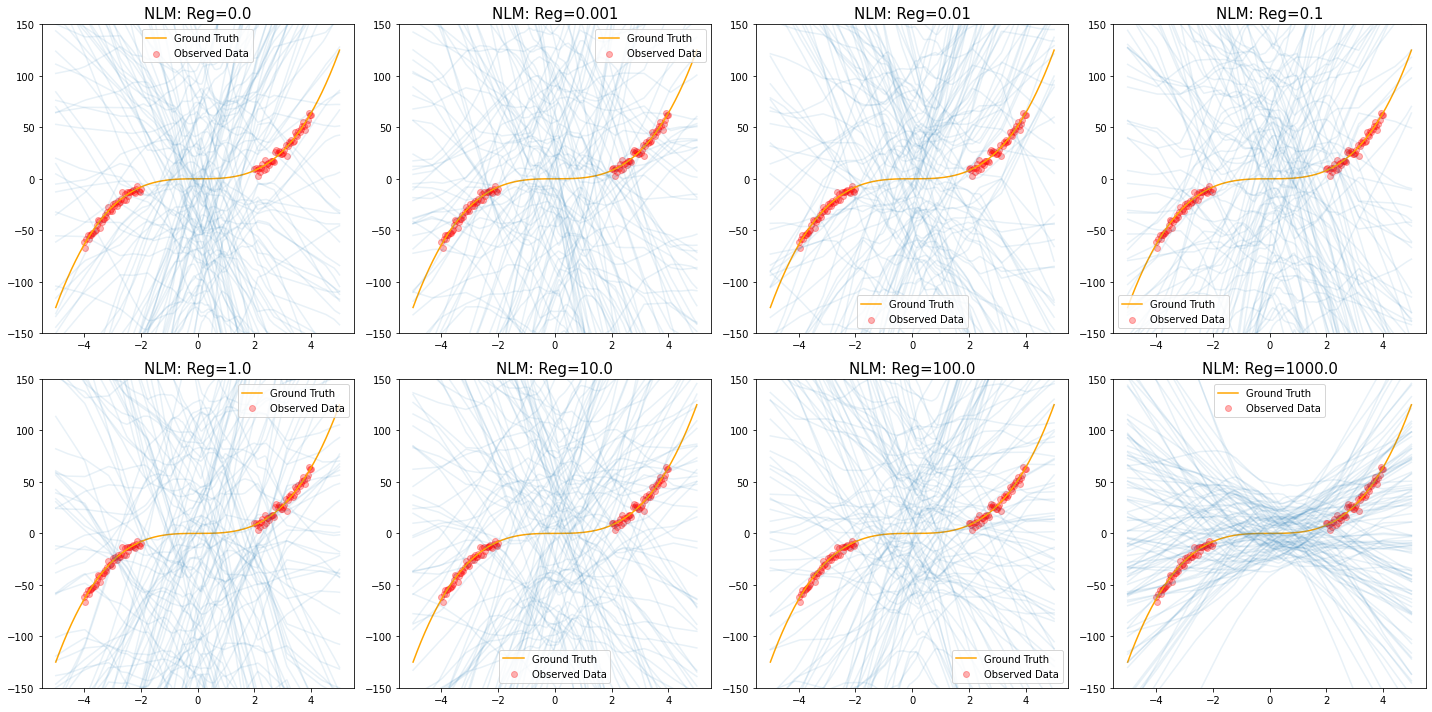

In [21]:
prior_mean = 0; prior_var = 9; noise_var = 9

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    nlm = nlm_list[i]
    y_prior = nlm.get_prior_preds(x_test, w_prior_mean = prior_mean, w_prior_cov=prior_var, noise_var=noise_var)
    ax.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax.plot(x_test[0,:], x_test[0,:]**3, color='orange', label="Ground Truth")
    ax.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
    ax.set_title(f"NLM: Reg={reg_grid[i]}",fontsize = 15)
    ax.set_ylim([-150, 150])
    ax.legend(loc='best')
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.show()



## Plot posterior samples

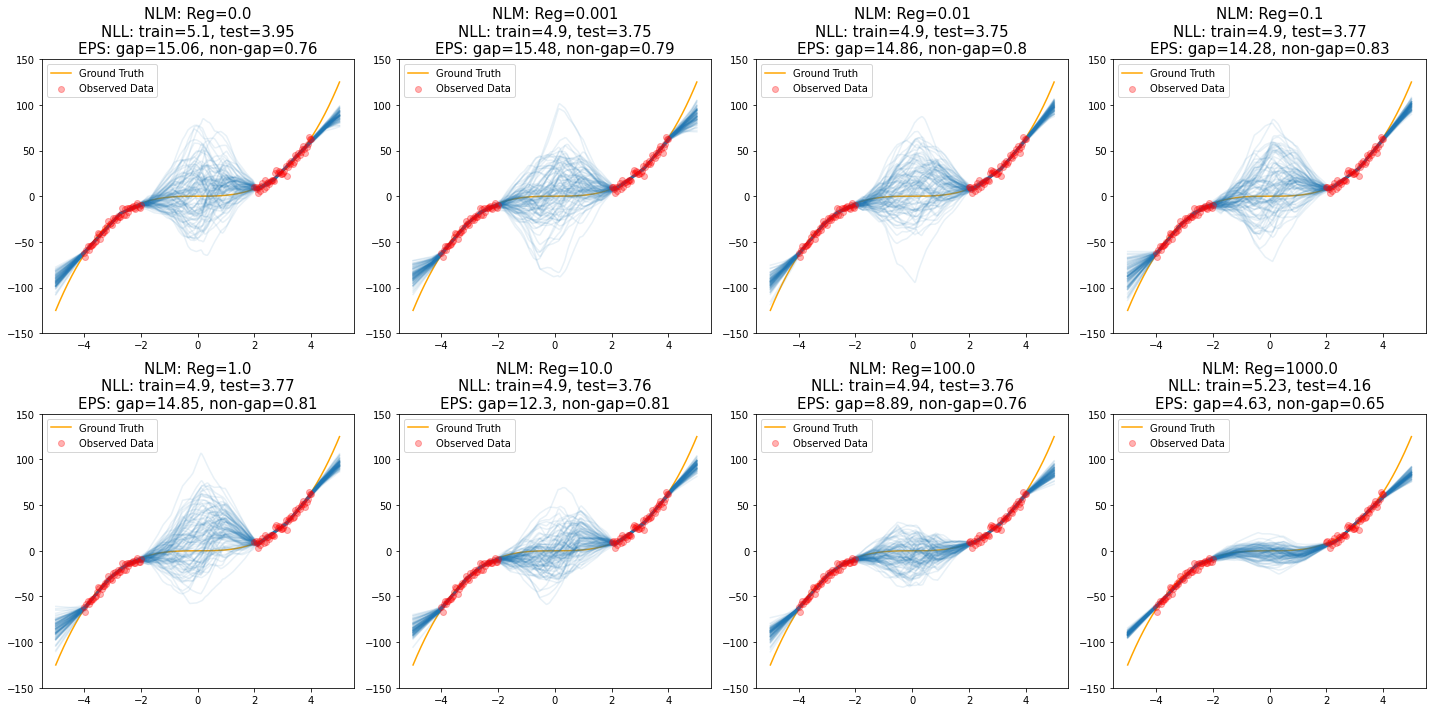

In [25]:
nll_train_list_nlm = []
nll_test_list_nlm = []
eps_gap_list_nlm = []
eps_non_gap_list_nlm = []

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    nlm = nlm_list[i]
    y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
#     y_posterior += np.random.normal(0, noise_var**0.5, size = y_posterior.shape)
    
    ax.scatter(x[0,:], y[0,:], color='red', zorder = 1000, alpha=0.3, label='Observed Data')
    ax.plot(x_test[0,:], x_test[0,:]**3, color='orange', label="Ground Truth")
    ax.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1)
    ax.set_ylim([-150, 150])
    
    y_posterior_train = nlm.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
    y_posterior_train_noise = y_posterior_train + np.random.normal(0, noise_var**0.5, size=y_posterior_train.shape)
    
    y_posterior_gap = nlm.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
    y_posterior_gap_noise = y_posterior_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_gap.shape)

    y_posterior_non_gap = nlm.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
    y_posterior_non_gap_noise = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_non_gap.shape)
    
    nll_train_list_nlm.append(np.round(neg_log_likelihood(y_posterior_train_noise, y, noise_var), 2))
    nll_test_list_nlm.append(np.round(neg_log_likelihood(y_posterior_non_gap_noise, y_test_non_gap, noise_var), 2))
    eps_gap_list_nlm.append(np.round(epistemic_uncertainty(y_posterior_gap), 2))
    eps_non_gap_list_nlm.append(np.round(epistemic_uncertainty(y_posterior_non_gap), 2))
    
    ax.set_title(f"NLM: Reg={reg_grid[i]}\nNLL: train={nll_train_list_nlm[i]}, test={nll_test_list_nlm[i]}\nEPS: gap={eps_gap_list_nlm[i]}, non-gap={eps_non_gap_list_nlm[i]}",fontsize=15)
    ax.legend(loc='best')
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.show()


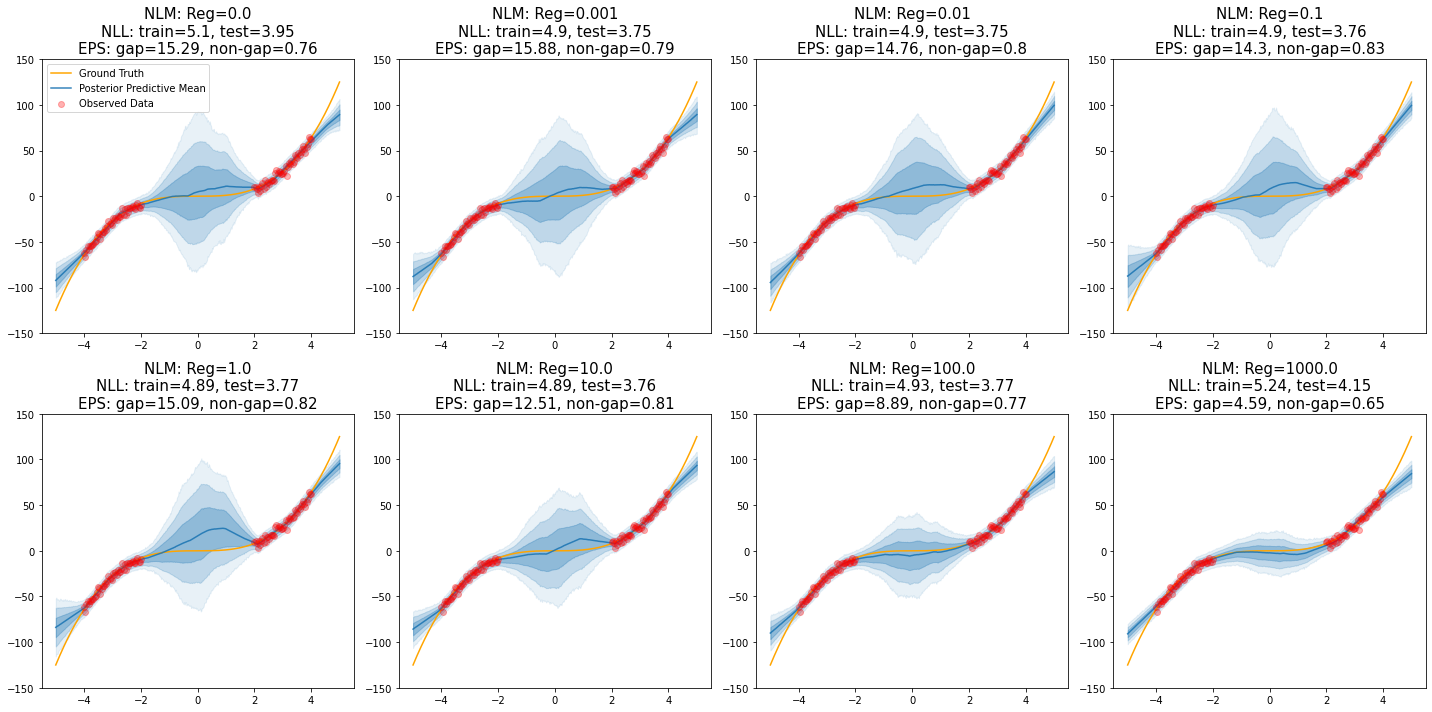

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    nlm = nlm_list[i]
    y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
    y_posterior += np.random.normal(0, noise_var**0.5, size = y_posterior.shape)
    
    pp_upper = np.percentile(y_posterior, 97.5, axis=0)
    pp_lower = np.percentile(y_posterior, 2.5, axis=0)
    pp_upper2 = np.percentile(y_posterior, 84, axis=0)
    pp_lower2 = np.percentile(y_posterior, 16, axis=0)
    pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
    pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
    pp_mean = np.mean(y_posterior, axis=0)

    ax.scatter(x[0,:], y[0,:], color='red', zorder = 1000, alpha=0.3, label='Observed Data')
    ax.plot(x_test[0,:], x_test[0,:]**3, color='orange', label="Ground Truth")
    ax.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
    ax.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2)
    ax.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3)
    ax.fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1)

    ax.set_ylim([-150, 150])
    ax.set_title(f"NLM: Reg={reg_grid[i]}\nNLL: train={nll_train_list_nlm[i]}, test={nll_test_list_nlm[i]}\nEPS: gap={eps_gap_list_nlm[i]}, non-gap={eps_non_gap_list_nlm[i]}",fontsize=15)

    if i == 0:
        ax.legend(loc='best')
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.show()

